# 2018-05-29 
Pour génerer les clouds d'entrainement, utiliser le script "Generate_Motion_Clouds" - easy clouds.

# MotionCouds generation
On va génerer en chunks et en 8 orientations avec 6 MC/par orientation :

In [1]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 300
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21
print('Btheta list : \n'+str( bw_values*180/np.pi))

theta_list = np.linspace(0,np.pi,16)

Btheta list : 
[  1.40625      1.42925612   1.45263862   1.47640365   1.50055748
   1.52510646   1.55005706   1.57541585   1.60118951   1.62738482
   1.65400868   1.68106811   1.70857023   1.73652228   1.76493163
   1.79380574   1.82315224   1.85297884   1.8832934    1.91410391
   1.94541847   1.97724534   2.00959289   2.04246964   2.07588426
   2.10984553   2.14436241   2.17944398   2.21509948   2.2513383
   2.28816999   2.32560424   2.36365091   2.40232002   2.44162175
   2.48156645   2.52216465   2.56342703   2.60536446   2.64798798
   2.69130882   2.73533838   2.78008827   2.82557025   2.87179632
   2.91877864   2.96652959   3.01506174   3.06438787   3.11452097
   3.16547425   3.21726111   3.26989521   3.32339039   3.37776075
   3.4330206    3.4891845    3.54626723   3.60428384   3.66324959
   3.72318001   3.78409089   3.84599827   3.90891844   3.97286799
   4.03786374   4.10392282   4.17106261   4.23930081   4.30865538
   4.37914458   4.45078698   4.52360145   4.59760715   4.67282

In [ ]:
for chunk_index, chunk in enumerate(bw_subsets) : #split into ranges
    for t in theta_list :
        if not os.path.exists('./clouds_boundary_BCE/chunk%s/%s' % (chunk_index,t)): #si le folder n'existe pas on le crée
            os.makedirs('./clouds_boundary_BCE/chunk%s/%s' % (chunk_index,t))

        for i_ax, B_theta in enumerate(chunk):
            mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0, theta=t, B_theta=B_theta)
            im = mc.random_cloud(mc_i)

            imageio.imwrite('./clouds_boundary_BCE/chunk%s/%s/B0 %s.png' % (chunk_index , t, (B_theta*180/np.pi) ) , im[:, :, 0])

            #plt.imshow(im[:, :, 0], cmap=plt.gray())
            #plt.text(5, 29, r'$B_\theta=%.1f$°' % (B_theta*180/np.pi), color='yellow', fontsize=32)
            #plt.show()  

On défini le réseau :

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch 
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.fc1 = nn.Linear(1690, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 20)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = self.sigm(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1690, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=20, bias=True)
  (sigm): Sigmoid()
)


On entraine sur du easy avec le CEL :

In [4]:
#One hot encoding, just in case BCE decides to work
def one_hot_v3(batch,depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)
#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=True,
                                             num_workers=1)

total_step = len(train_loader)
loss_list = []
time_list = []
t=0

epochs = 10

import time
start_time = time.time()
print("Started training")

for epoch in range(epochs) :
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward pass
        outputs = model(images)
        #print(outputs.size())

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Started training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/10], Step [100/480], Loss: 2.9966
Epoch [1/10], Step [200/480], Loss: 2.9805
Epoch [1/10], Step [300/480], Loss: 2.9984
Epoch [1/10], Step [400/480], Loss: 2.9794
Epoch [2/10], Step [100/480], Loss: 2.9934
Epoch [2/10], Step [200/480], Loss: 2.9709
Epoch [2/10], Step [300/480], Loss: 2.9892
Epoch [2/10], Step [400/480], Loss: 2.9170
Epoch [3/10], Step [100/480], Loss: 2.9639
Epoch [3/10], Step [200/480], Loss: 3.0142
Epoch [3/10], Step [300/480], Loss: 3.0087
Epoch [3/10], Step [400/480], Loss: 2.9285
Epoch [4/10], Step [100/480], Loss: 2.9892
Epoch [4/10], Step [200/480], Loss: 2.9635
Epoch [4/10], Step [300/480], Loss: 2.9104
Epoch [4/10], Step [400/480], Loss: 2.8805
Epoch [5/10], Step [100/480], Loss: 2.9839
Epoch [5/10], Step [200/480], Loss: 2.9990
Epoch [5/10], Step [300/480], Loss: 2.9630
Epoch [5/10], Step [400/480], Loss: 2.7349
Epoch [6/10], Step [100/480], Loss: 2.3774
Epoch [6/10], Step [200/480], Loss: 2.5442
Epoch [6/10], Step [300/480], Loss: 2.1304
Epoch [6/10

Et maintenant on teste sur les chunks :

In [5]:
import math
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 300
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21

theta_list = np.linspace(0,np.pi,16)

ez_range_list = []
ez_acc_list = []

for chunk_index, chunk in enumerate(bw_subsets):
    test_loss = 0
    correct = 0
    data_set = datasets.ImageFolder(root='clouds_boundary_BCE/chunk%s'%chunk_index,
                                transform=data_transform)
    data_loader = torch.utils.data.DataLoader(data_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)
    
    #labels is (theta-thetamean)/4btheta²
    for data, target in data_loader:
        data = Variable(data, volatile=True)
        
        #NEW LABEL
        B_theta = np.mean(chunk)*180/np.pi
        #print('Mean B_theta = %s' %B_theta)
        
        Theta_zero = np.mean(np.linspace(0,np.pi,16))
        #print('Theta_zero = %s' % Theta_zero)
        
        target_list =[]
        for i,t in enumerate(target):
            Theta = data_set.classes[target[i]]
            target_list.append(float(Theta))
        #print('List of thetas = %s' % target_list)
        
        new_label = []
        for lab in range(len(target_list)):
            new_lab = math.cos(target_list[lab]-Theta_zero)
            new_lab = new_lab/4 * (B_theta) **2
            #print(new_lab)
            new_label.append(int(new_lab))
            
        new_label = torch.LongTensor(new_label)
        new_label = Variable(new_label)
        
        net_out = model(data)


        test_loss += criterion(net_out, new_label).data[0]
        pred = net_out.data.max(1)[1] #index of max_log probability
        correct += pred.eq(new_label.data).sum() #sum up pred equals target in the batch
    
    test_loss /= len(data_loader.dataset) #loss = loss/length set
    #print("Chunk b_theta range : %s : %s" % (chunk[1]*180/np.pi, chunk[-1]*180/np.pi))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    ez_range_list.append( ( chunk[1]*180/np.pi + chunk[-1]*180/np.pi ) / 2 )
    ez_acc_list.append(100 * correct /len(data_loader.dataset))
    



Test set: Average loss: 4.6513, Accuracy: 12/96 (12%)



/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 4.5343, Accuracy: 12/96 (12%)


Test set: Average loss: 4.6884, Accuracy: 12/96 (12%)


Test set: Average loss: 4.4126, Accuracy: 12/96 (12%)


Test set: Average loss: 4.5956, Accuracy: 12/96 (12%)


Test set: Average loss: 4.8370, Accuracy: 12/96 (12%)


Test set: Average loss: 4.5270, Accuracy: 12/96 (12%)


Test set: Average loss: 4.5445, Accuracy: 12/96 (12%)


Test set: Average loss: 4.4062, Accuracy: 12/96 (12%)


Test set: Average loss: 4.0774, Accuracy: 12/96 (12%)


Test set: Average loss: 3.9334, Accuracy: 12/96 (12%)


Test set: Average loss: 3.1083, Accuracy: 12/96 (12%)


Test set: Average loss: 2.7090, Accuracy: 36/96 (37%)


Test set: Average loss: 2.0716, Accuracy: 42/96 (43%)


Test set: Average loss: 2.8817, Accuracy: 24/96 (25%)


Test set: Average loss: 3.8818, Accuracy: 18/96 (18%)


Test set: Average loss: 3.9104, Accuracy: 18/96 (18%)


Test set: Average loss: 4.0148, Accuracy: 12/96 (12%)


Test set: Average loss: 4.4898, Accuracy: 12/96

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THNN/generic/ClassNLLCriterion.c:97

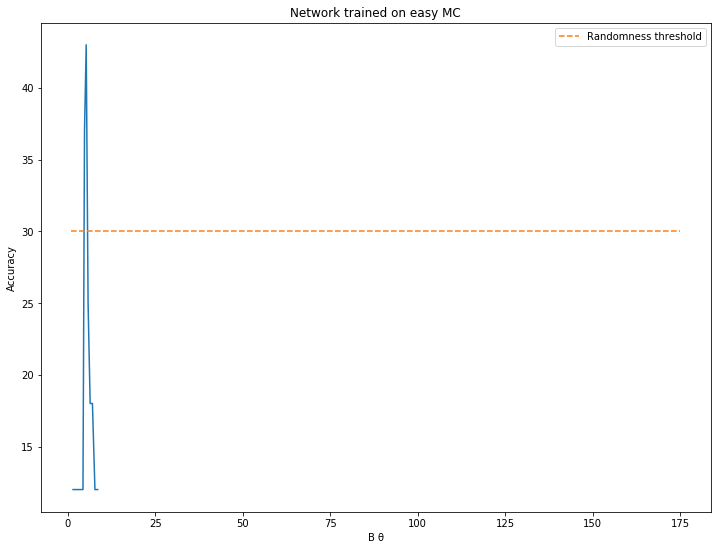

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 9]
plt.ylabel("Accuracy")
plt.xlabel("B θ")
plt.title("Network trained on easy MC")

plt.plot(ez_range_list, ez_acc_list)
plt.plot([1,175],[30,30],'--', label = 'Randomness threshold')
plt.legend()
plt.show()